In [3]:
import os
import tensorflow as tf
import pathlib
import glob
import numpy as np

In [4]:
window_size=19
input_size=200

In [5]:
path_x_train = r"E:\Eric_HSI\excise2\np_data\x_train" + ".npy"
path_x_val = r"E:\Eric_HSI\excise2\np_data\x_val" + ".npy"
path_y_train = r"E:\Eric_HSI\excise2\np_data\y_train" + ".npy"
path_y_val = r"E:\Eric_HSI\excise2\np_data\y_val" + ".npy"

# path_X_train = r"F:\deeplearning\Geyi_HSI\np_data\X_train" + ".npy"
# path_X_val = r"F:\deeplearning\Geyi_HSI\np_data\X_val" + ".npy"
# path_y_train = r"F:\deeplearning\Geyi_HSI\np_data\y_train" + ".npy"
# path_y_val = r"F:\deeplearning\Geyi_HSI\np_data\y_val" + ".npy"

In [6]:
x_train = np.load(path_x_train)
x_val = np.load(path_x_val)
y_train = np.load(path_y_train)
y_val = np.load(path_y_val)

In [7]:
# 创建dataset
batch_size = 16
db = tf.data.Dataset.from_tensor_slices((x_train, x_val))   # 训练集和标签！！
db = db.shuffle(2049).batch(batch_size).repeat()

db_test = tf.data.Dataset.from_tensor_slices((y_train, y_val))
db_test = db_test.batch(batch_size)
db

<RepeatDataset shapes: ((None, 200, 19, 19, 1), (None, 16)), types: (tf.float32, tf.float32)>

In [8]:
x_train.shape, x_val.shape, y_train.shape, y_val.shape

((2049, 200, 19, 19, 1), (2049, 16), (8200, 200, 19, 19, 1), (8200, 16))

In [9]:
model = tf.keras.Sequential([
    tf.keras.layers.Conv3D(32, kernel_size=(3, 3, 3), input_shape=(200, 19, 19, 1), strides=(5, 1, 1), activation='relu'),  # 17
    tf.keras.layers.BatchNormalization(),

    tf.keras.layers.Conv3D(32, kernel_size=(3, 3, 3), padding='same', activation='relu'),
    tf.keras.layers.BatchNormalization(),
    # tf.keras.layers.MaxPooling3D(pool_size=2),  # 8

    tf.keras.layers.Conv3D(64, kernel_size=(3, 3, 3), activation='relu'),
    tf.keras.layers.BatchNormalization(),

    tf.keras.layers.Conv3D(64, kernel_size=(3, 3, 3), activation='relu'),
    tf.keras.layers.BatchNormalization(),

    tf.keras.layers.Flatten(),

    tf.keras.layers.Dense(128, activation='relu'),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Dropout(0.5),

    tf.keras.layers.Dense(128, activation='relu'),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Dropout(0.5),

    tf.keras.layers.Dense(16, activation='softmax')]
)

In [10]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv3d (Conv3D)              (None, 40, 17, 17, 32)    896       
_________________________________________________________________
batch_normalization (BatchNo (None, 40, 17, 17, 32)    128       
_________________________________________________________________
conv3d_1 (Conv3D)            (None, 40, 17, 17, 32)    27680     
_________________________________________________________________
batch_normalization_1 (Batch (None, 40, 17, 17, 32)    128       
_________________________________________________________________
conv3d_2 (Conv3D)            (None, 38, 15, 15, 64)    55360     
_________________________________________________________________
batch_normalization_2 (Batch (None, 38, 15, 15, 64)    256       
_________________________________________________________________
conv3d_3 (Conv3D)            (None, 36, 13, 13, 64)    1

In [11]:
# keras.backend.set_learning_phase(0) # train mode
# keras.backend.set_learning_phase(1) # predict mode
# 之所以这么区分，是因为某些层在预测和训练时不同,有待进一步研究！！

In [12]:
lr_reduce = tf.keras.callbacks.ReduceLROnPlateau('val_loss', patience=3, factor=0.5, min_lr=0.00001)
model.compile(
              optimizer='adam',
              loss='categorical_crossentropy',
              metrics=['acc'])

In [13]:
epoch = 50

In [14]:
history = model.fit(
                    db,
                    batch_size=batch_size,
                    epochs=epoch,
                    steps_per_epoch=341,
                    validation_data=db_test,
                    callbacks=[lr_reduce]
                    )

Epoch 1/50


UnknownError:  Failed to get convolution algorithm. This is probably because cuDNN failed to initialize, so try looking to see if a warning log message was printed above.
	 [[node sequential/conv3d/Conv3D (defined at <ipython-input-14-7fcaf4c47050>:1) ]] [Op:__inference_train_function_3025]

Function call stack:
train_function


 1. 使用repeat() 解决如下报错：
    - WARNING:tensorflow:Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches (in this case, 414 batches). You may need to use the repeat() function when building your dataset.   
2. 解决：
    - 方式一：
    - 如果使用 model.fit(train_dataset, validation_data=test_dataset, steps_per_epoch=M, epochs=N)，即同时steps_per_epoch和epochs的话，则要求把训练集和验证集都拷贝N份(epochs份)，因为使用了steps_per_epoch之后，每次epoch的遍历是对不同份的训练集和验证集进行遍历，不再是对同一份训练集和验证集进行遍历，因此一开始就要拷贝N份(epochs份)的源训练集和源验证集，供以遍历epoch次。可以使用repeat(epochs)对数据集进行拷贝epochs份。
    - 方式二： 
    - 如果使用 model.fit(train_dataset, validation_data=test_dataset, epochs=N)，只使用了epochs的话，那么每次epoch的遍历都是对同一份训练集和验证集进行遍历，便不需要把训练集和验证集都拷贝N份(epochs份)，其中steps_per_epoch值不需要传入，即会在第一次epoch的遍历中自动计算steps_per_epoch值。
3. 例子：batch、repeat、steps_per_epoch、epochs的使用
    1. 先用 batch(批次大小) 然后才用 repeat(重复次数)， 比如：repeat(2)重复数据集2次，即复制一份数据集，最终即有两份数据集。
    2. steps_per_epoch 即表示 一个epoch 里面遍历批量数据的次数，即遍历多少个批量数据完成一个epoch。
    3. 应保证要输入到模型的数据集(包括训练集/验证集)的批量个数都均为steps_per_epoch*epoch。

    4. fit中没有定义steps_per_epoch，只定义了epochs的话，那么只会对同一份数据集进行遍历epochs次进行训练。如果fit中同时有传训练集和验证集validation_data进行训练/验证的话，那么均为对同一份训练集和验证集进行遍历epochs次进行训练/验证。打印的训练信息格式如下：当前步数step/总步数steps - ETA:剩余训练时间  - loss - accuracy   
    5. fit中同时定义了steps_per_epoch和epochs的话，那么表示对数据集进行遍历epochs次进行训练，并且每个epoch中遍历steps_per_epoch个批量数据。但要注意的是此处所说的对数据集进行遍历epochs次指的不是对同一份数据集遍历epochs次，而是对epochs份数据集遍历epochs次，而每份数据集遍历1次，因此需要对原始数据集拷贝epochs份，才能每份数据集遍历1次，一共遍历epochs次进行训练。如果fit中同时有传训练集和验证集validation_data进行训练/验证的话，那么同时要把训练集和验证集validation_data都拷贝epochs份。可以使用repeat(epochs)对数据集进行拷贝epochs份。第一个epoch打印的训练信息格式如下：
    - 当前步数step/Unknown - ETA:剩余训练时间  - loss: - accuracy: 
    - 第一个epoch之后的每个epoch打印的训练信息格式如下：（因为经过第一个epoch之后底层就已经计算好每个epoch需要遍历多少个批量数据，即得出总步数steps） 
    - 当前步数step/总步数steps - ETA:剩余训练时间  - loss - accuracy

4. 使用顺序：from_tensor_slices -> map -> shuffle -> batch -> repeat -> prefetch

In [21]:
loss, acc = model.evaluate(y_train,
                           y_val,
                           batch_size=batch_size)

loss, acc

513/513 [==============================] - 10s 20ms/step - loss: 0.0371 - acc: 0.9915


(0.03707822412252426, 0.9914634227752686)

In [22]:
import matplotlib.pyplot as plt 

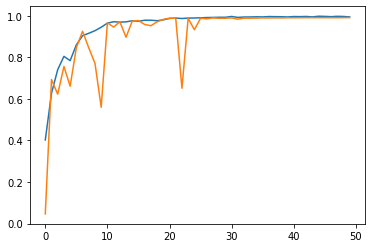

In [24]:
plt.plot(history.epoch, history.history['acc'])
plt.plot(history.epoch, history.history['val_acc'])

In [25]:
model_dir = r'E:\Eric_HSI\excise2\weights'
print('acc:', acc)
if not os.path.exists(model_dir):
    os.mkdir(model_dir)
model.save_weights(r'E:\Eric_HSI\excise2\weights\model_weight.ckpt')
print('model_weights have been saved at ' + model_dir)

acc: 0.9914634227752686
model_weights have been saved at E:\Eric_HSI\excise2\weights


In [26]:
del model

In [27]:
model = tf.keras.Sequential([
    tf.keras.layers.Conv3D(32, kernel_size=(3, 3, 3), input_shape=(200, 19, 19, 1), strides=(5, 1, 1), activation='relu'),  # 17
    tf.keras.layers.BatchNormalization(),

    tf.keras.layers.Conv3D(32, kernel_size=(3, 3, 3), padding='same', activation='relu'),
    tf.keras.layers.BatchNormalization(),
    # tf.keras.layers.MaxPooling3D(pool_size=2),  # 8

    tf.keras.layers.Conv3D(64, kernel_size=(3, 3, 3), activation='relu'),
    tf.keras.layers.BatchNormalization(),

    tf.keras.layers.Conv3D(64, kernel_size=(3, 3, 3), activation='relu'),
    tf.keras.layers.BatchNormalization(),

    tf.keras.layers.Flatten(),

    tf.keras.layers.Dense(128, activation='relu'),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Dropout(0.5),

    tf.keras.layers.Dense(128, activation='relu'),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Dropout(0.5),

    tf.keras.layers.Dense(16, activation='softmax')]
)

In [1]:
model.summary()

NameError: name 'model' is not defined

In [2]:
lr_reduce = tf.keras.callbacks.ReduceLROnPlateau('val_loss', patience=3, factor=0.5, min_lr=0.00001)
model.compile(
    optimizer='adam',
    loss='categorical_crossentropy',
    metrics=['acc'])

NameError: name 'tf' is not defined

In [29]:
model.load_weights(r'E:\Eric_HSI\excise2\weights\model_weight.ckpt')

In [30]:
loss, acc = model.evaluate(y_train,
                           y_val,
                           batch_size=batch_size)

loss, acc

513/513 [==============================] - 10s 20ms/step - loss: 0.0371 - acc: 0.9915


(0.03707822412252426, 0.9914634227752686)